# Artificial Neural Networks

## Dataset

Dataset source can be viewed [here](https://www.kaggle.com/yasserh/breast-cancer-dataset).

Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

The key challenges against it’s detection is how to classify tumors into malignant (cancerous) or benign(non cancerous). We ask you to complete the analysis of classifying these tumors using machine learning (with SVMs) and the Breast Cancer Wisconsin (Diagnostic) Dataset.

## Imports

In [1]:
from math import e

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.core.display import Markdown
from IPython.core.display_functions import display
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler

## Global parameters setup

In [2]:
# @formatter:off
# %matplotlib inline
# @formatter:on

random_state = 5100
np.random.seed(random_state)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv('./data/breast-cancer.csv')
display(df.shape)
display(df.head())
display(df.info())

(569, 32)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

None

In [4]:
def move_col_to_end (df, col_name):
    return df[[c for c in df if c != col_name]
              + [c for c in df if c == col_name]]

def standardise_and_normalise (df):
    df = df.copy()
    feature_columns = df.columns[:-1]
    df[feature_columns] = StandardScaler().fit_transform(df[feature_columns])

    encoder = LabelBinarizer().fit(df['diagnosis'])
    df['diagnosis'] = encoder.transform(df['diagnosis'])
    return df, encoder

df.drop('id', axis=1, inplace=True)
df = move_col_to_end(df, "diagnosis")

df, encoder = standardise_and_normalise(df)

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


In [5]:
print(f"There are {df.isnull().any(axis=1).sum()} rows with missing data.")
print(f"There are {len(df[df.duplicated() == True])} duplicated rows.")

There are 0 rows with missing data.
There are 0 duplicated rows.


In [6]:
display(df.nunique(dropna=True))

radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
diagnosis                    2
dtype: int64

In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,-1.373633e-16,1.000880,-2.029648,-0.689385,-0.215082,0.469393,3.971288
texture_mean,569.0,6.868164e-17,1.000880,-2.229249,-0.725963,-0.104636,0.584176,4.651889
perimeter_mean,569.0,-1.248757e-16,1.000880,-1.984504,-0.691956,-0.235980,0.499677,3.976130
area_mean,569.0,-2.185325e-16,1.000880,-1.454443,-0.667195,-0.295187,0.363507,5.250529
smoothness_mean,569.0,-8.366672e-16,1.000880,-3.112085,-0.710963,-0.034891,0.636199,4.770911
compactness_mean,569.0,1.873136e-16,1.000880,-1.610136,-0.747086,-0.221940,0.493857,4.568425
concavity_mean,569.0,4.995028e-17,1.000880,-1.114873,-0.743748,-0.342240,0.526062,4.243589
concave points_mean,569.0,-4.995028e-17,1.000880,-1.261820,-0.737944,-0.397721,0.646935,3.927930
symmetry_mean,569.0,1.748260e-16,1.000880,-2.744117,-0.703240,-0.071627,0.530779,4.484751
fractal_dimension_mean,569.0,4.745277e-16,1.000880,-1.819865,-0.722639,-0.178279,0.470983,4.910919


In [8]:
def remove_outliers (df):
    filtered_entries = (np.abs(zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)
    return df[filtered_entries]

# df = remove_outliers(df)

<AxesSubplot:>

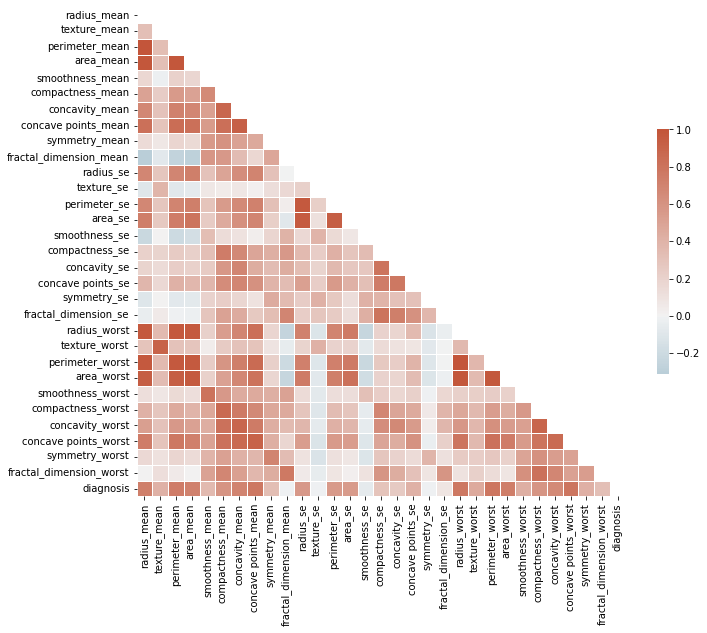

In [9]:
def plot_correlation (df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    display(sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5}))

plot_correlation(df)
# plot_correlation(remove_outliers(df))

## Data split

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df["diagnosis"], random_state=random_state)
df_train, df_validate = train_test_split(df_train, test_size=0.3, stratify=df_train["diagnosis"],
                                         random_state=random_state)

y_train = df_train.iloc[:, [-1]]
X_train = df_train.drop(y_train.columns, axis=1)

y_validate = df_validate.iloc[:, [-1]]
X_validate = df_validate.drop(y_validate.columns, axis=1)

y_test = df_test.iloc[:, [-1]]
X_test = df_test.drop(y_test.columns, axis=1)

print(f"df_train has {df_train.shape[0]} rows")
print(f"df_validate has {df_validate.shape[0]} rows")
print(f"df_test has {df_test.shape[0]} rows")

df_train has 278 rows
df_validate has 120 rows
df_test has 171 rows


## Helper functions

In [11]:
def plot_results (history, y_predicted, y_true, y_labels=None):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    ax = plt.subplot(1, 3, 3)
    plt.title('Test')
    ConfusionMatrixDisplay.from_predictions(y_true, y_predicted, display_labels=y_labels, ax=ax)

    plt.tight_layout()
    plt.show()

    display(pd.DataFrame(data=precision_recall_fscore_support(y_true, y_predicted, zero_division=0),
                         columns=y_labels,
                         index=["Precision", "Recall", "F-Score", "Support"]))

def train_test_plot_network (compile_network, network_fit,
                             X_train, y_train,
                             X_validate, y_validate,
                             X_test, y_test,
                             y_labels=None):
    network = compile_network()
    history = network_fit(network, X_train, y_train, X_validate, y_validate)
    y_predicted = np.round(network.predict(X_test)).astype(int)
    plot_results(history, y_predicted, y_test, y_labels)
    return history

## Reference results (Random forest)

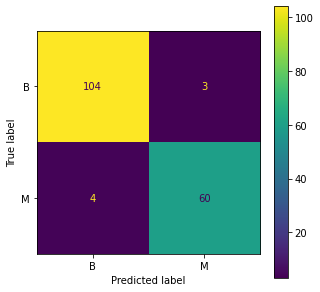

,B,M
Precision,0.962963,0.952381
Recall,0.971963,0.937500
F-Score,0.967442,0.944882
Support,107.000000,64.000000


In [12]:
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
random_forest.fit(X_train, y_train.values.ravel())
random_forest_predicted = random_forest.predict(X_test)

plt.figure(figsize=(5, 5))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_test, random_forest_predicted, display_labels=encoder.classes_, ax=ax)
plt.show()

display(pd.DataFrame(data=precision_recall_fscore_support(y_test, random_forest_predicted),
                     columns=encoder.classes_,
                     index=["Precision", "Recall", "F-Score", "Support"]))

## Simple Neural Network

2022-03-15 21:39:43.373730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 21:39:43.413976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-15 21:39:43.414000: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-15 21:39:43.414921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

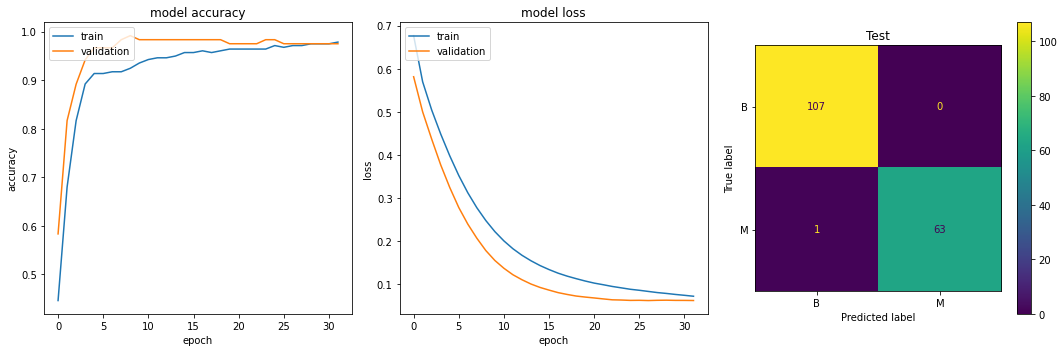

,B,M
Precision,0.990741,1.000000
Recall,1.000000,0.984375
F-Score,0.995349,0.992126
Support,107.000000,64.000000


In [13]:
def compile_simple_network ():
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation="relu", input_shape=(len(X_train.columns),)))
    network.add(layers.Dense(units=16, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy",
                    optimizer="rmsprop",
                    metrics=["accuracy"])
    return network

def simple_network_fit (network, X_train, y_train, X_validate, y_validate):
    return network.fit(X_train,
                       y_train,
                       epochs=32,
                       batch_size=32,
                       verbose=0,
                       validation_data=(X_validate, y_validate))

train_test_plot_network(compile_simple_network,
                        simple_network_fit,
                        X_train, y_train,
                        X_validate, y_validate,
                        X_test, y_test,
                        y_labels=encoder.classes_)

## Custom activation functions

In [14]:
def compile_custom_activation_network (units=16, activation="relu", output_activation="sigmoid"):
    network = models.Sequential()
    network.add(layers.Dense(units=units, activation=activation, input_shape=(len(X_train.columns),)))
    network.add(layers.Dense(units=units, activation=activation))
    network.add(layers.Dense(units=1, activation=output_activation))
    network.compile(loss="binary_crossentropy",
                    optimizer="rmsprop",
                    metrics=["accuracy"])
    return network

relu — Activation function


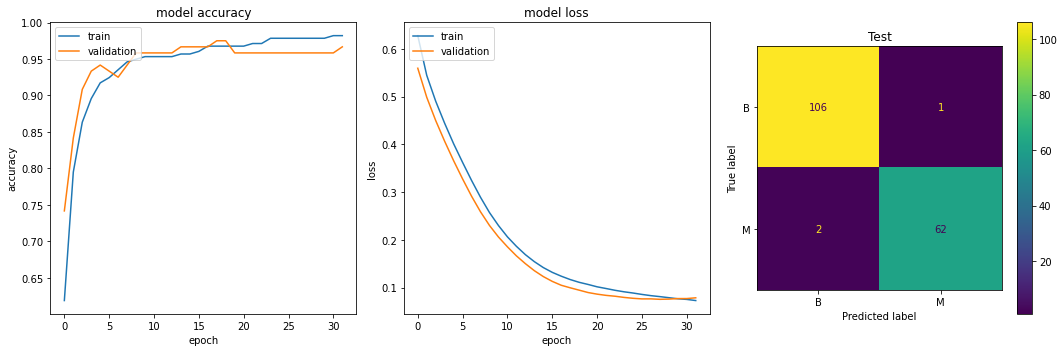

,B,M
Precision,0.981481,0.984127
Recall,0.990654,0.968750
F-Score,0.986047,0.976378
Support,107.000000,64.000000


---

gelu — Activation function


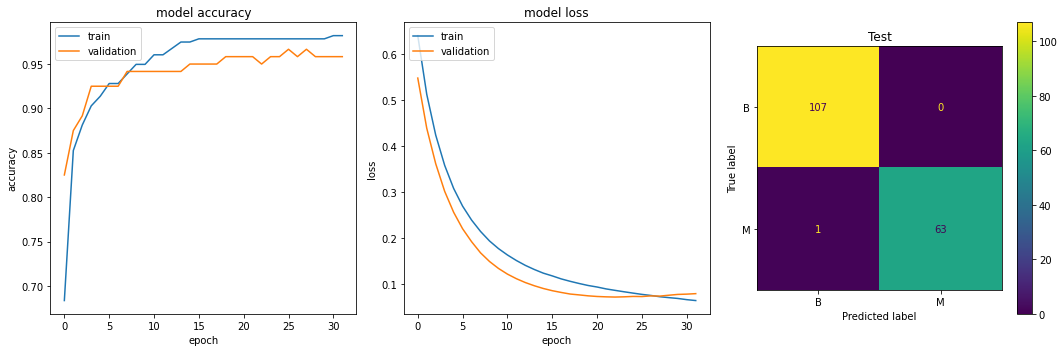

,B,M
Precision,0.990741,1.000000
Recall,1.000000,0.984375
F-Score,0.995349,0.992126
Support,107.000000,64.000000


---

sigmoid — Activation function


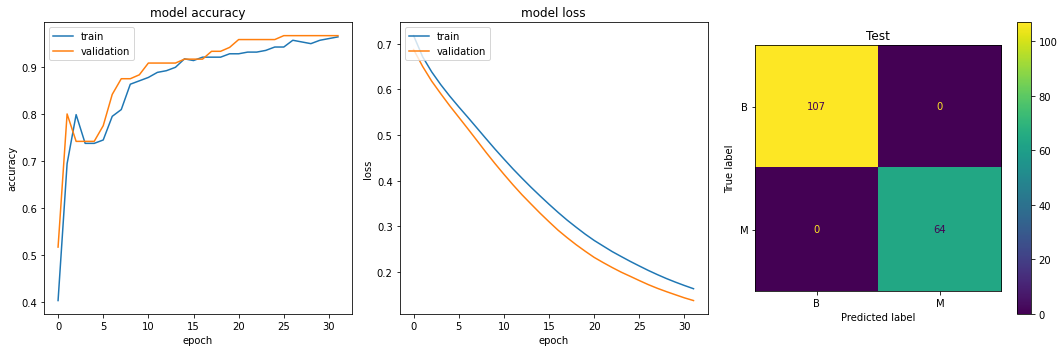

,B,M
Precision,1.0,1.0
Recall,1.0,1.0
F-Score,1.0,1.0
Support,107.0,64.0


---

softmax — Activation function


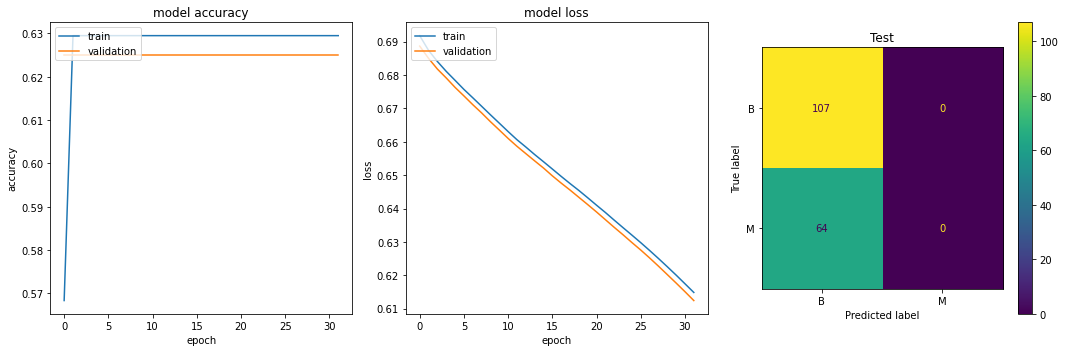

,B,M
Precision,0.625731,0.0
Recall,1.000000,0.0
F-Score,0.769784,0.0
Support,107.000000,64.0


---

softplus — Activation function


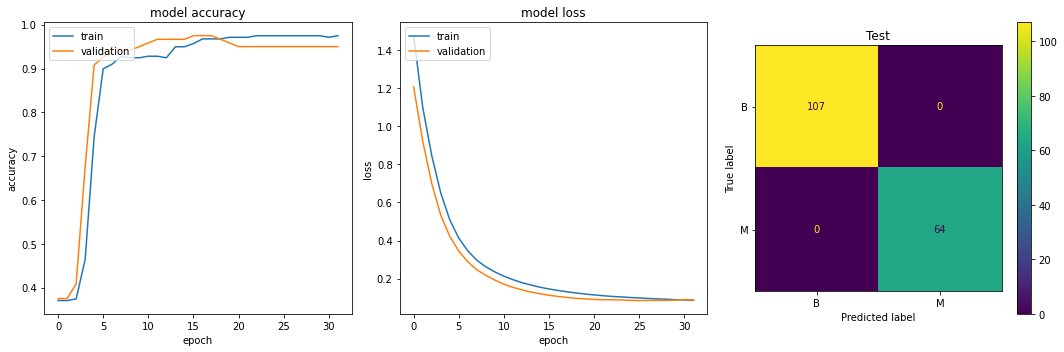

,B,M
Precision,1.0,1.0
Recall,1.0,1.0
F-Score,1.0,1.0
Support,107.0,64.0


---

softsign — Activation function


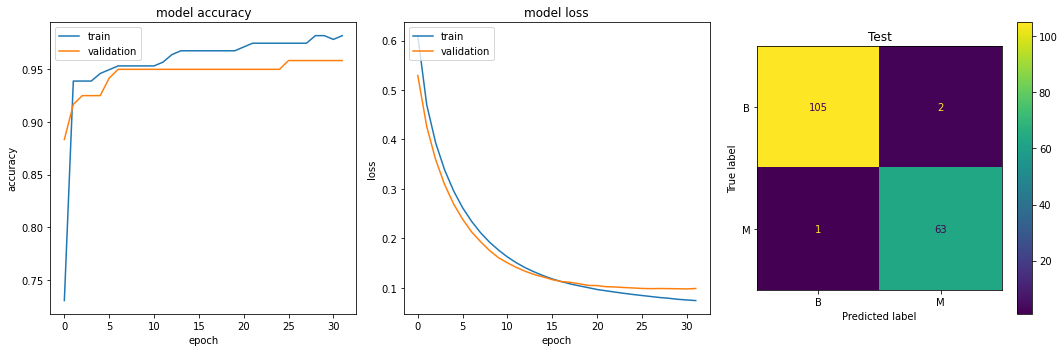

,B,M
Precision,0.990566,0.969231
Recall,0.981308,0.984375
F-Score,0.985915,0.976744
Support,107.000000,64.000000


---

tanh — Activation function


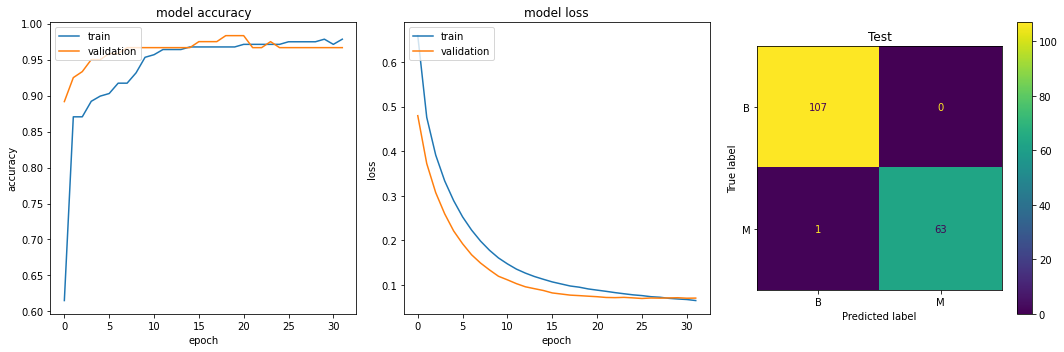

,B,M
Precision,0.990741,1.000000
Recall,1.000000,0.984375
F-Score,0.995349,0.992126
Support,107.000000,64.000000


---

selu — Activation function


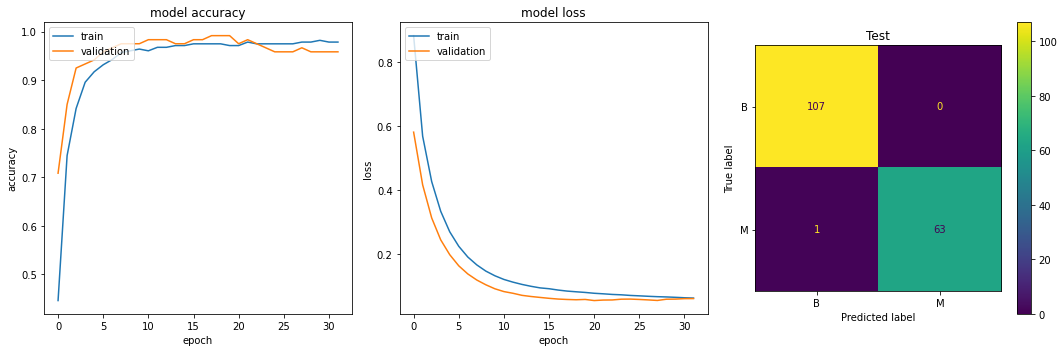

,B,M
Precision,0.990741,1.000000
Recall,1.000000,0.984375
F-Score,0.995349,0.992126
Support,107.000000,64.000000


---

elu — Activation function


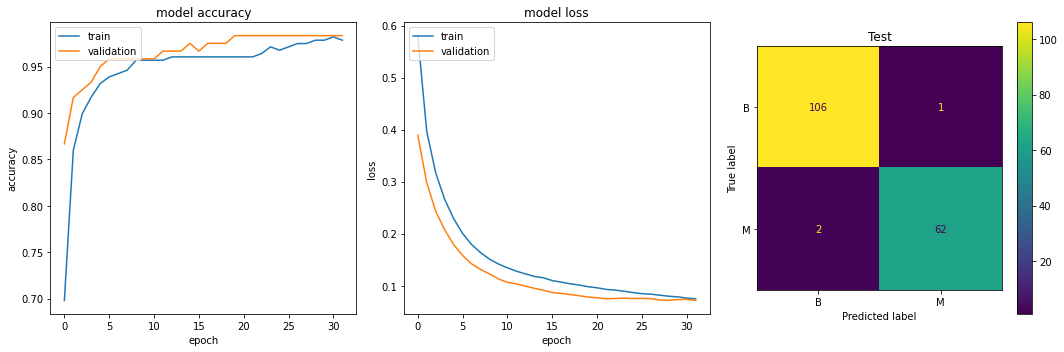

,B,M
Precision,0.981481,0.984127
Recall,0.990654,0.968750
F-Score,0.986047,0.976378
Support,107.000000,64.000000


---

my_custom_fn_1 — Activation function


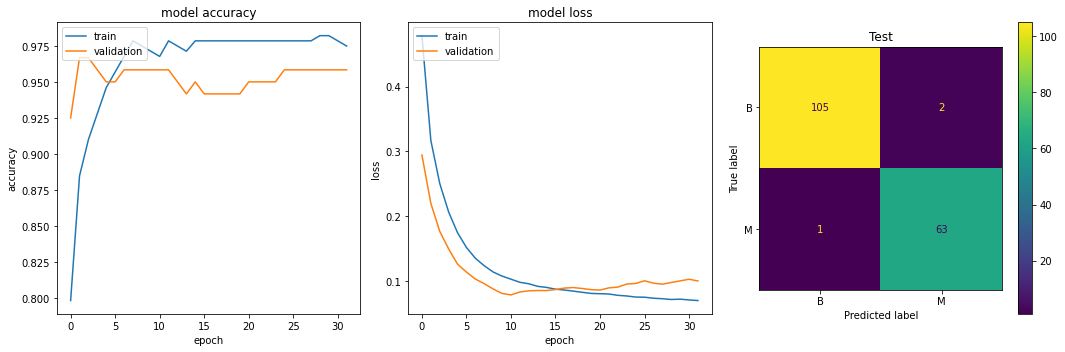

,B,M
Precision,0.990566,0.969231
Recall,0.981308,0.984375
F-Score,0.985915,0.976744
Support,107.000000,64.000000


---

my_custom_fn_2 — Activation function


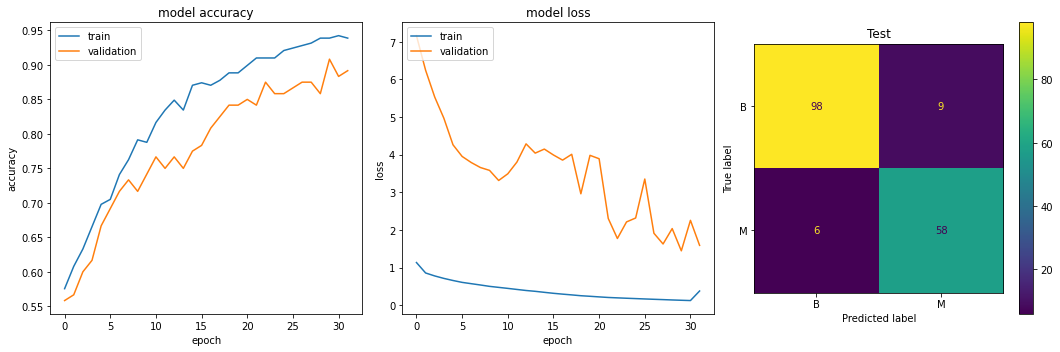

,B,M
Precision,0.942308,0.865672
Recall,0.915888,0.906250
F-Score,0.928910,0.885496
Support,107.000000,64.000000


---

my_custom_fn_3 — Activation function


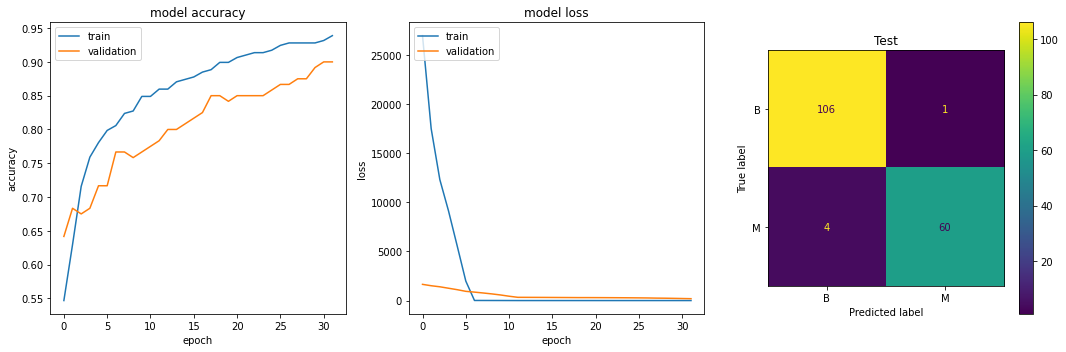

,B,M
Precision,0.963636,0.983607
Recall,0.990654,0.937500
F-Score,0.976959,0.960000
Support,107.000000,64.000000


---

my_custom_fn_4 — Activation function


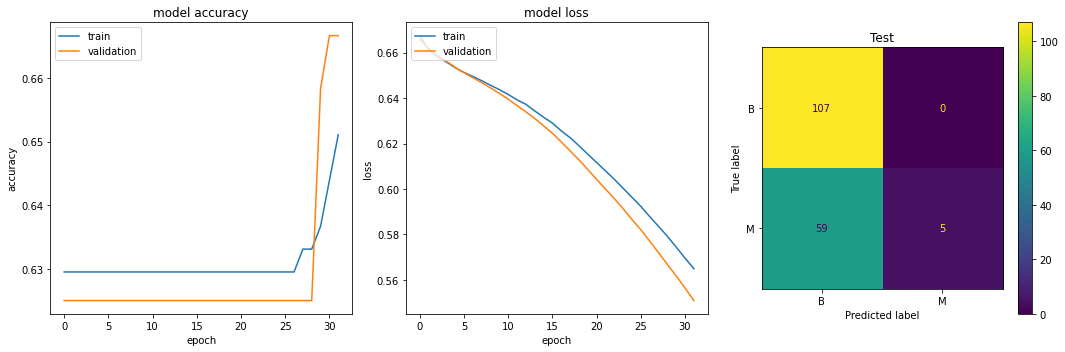

,B,M
Precision,0.644578,1.000000
Recall,1.000000,0.078125
F-Score,0.783883,0.144928
Support,107.000000,64.000000


---

my_custom_fn_5 — Activation function


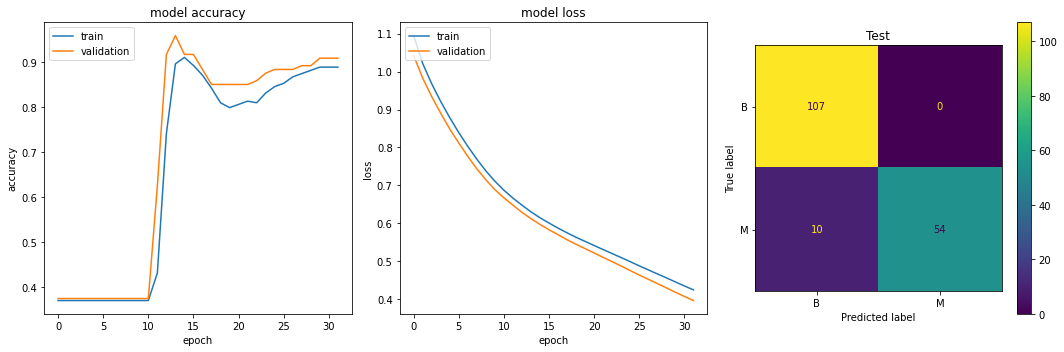

,B,M
Precision,0.914530,1.000000
Recall,1.000000,0.843750
F-Score,0.955357,0.915254
Support,107.000000,64.000000


---

In [15]:
def my_custom_fn_1 (x):
    return x

def my_custom_fn_2 (x):
    return x ** 2

def my_custom_fn_3 (x):
    return tf.math.maximum(0.0, x ** 3)

def my_custom_fn_4 (x):
    return 1 / (1 + tf.constant(e) ** (- 0.2 * x))

def my_custom_fn_5 (x):
    return 1 / (1 + tf.constant(e) ** (- 0.5 * x))

custom_activation_functions = [
    ("relu", "relu"),
    ("gelu", "gelu"),
    ("sigmoid", "sigmoid"),
    ("softmax", "softmax"),
    ("softplus", "softplus"),
    ("softsign", "softsign"),
    ("tanh", "tanh"),
    ("selu", "selu"),
    ("elu", "elu"),
    (my_custom_fn_1.__name__, my_custom_fn_1),
    (my_custom_fn_2.__name__, my_custom_fn_2),
    (my_custom_fn_3.__name__, my_custom_fn_3),
    (my_custom_fn_4.__name__, my_custom_fn_4),
    (my_custom_fn_5.__name__, my_custom_fn_5),
]
for (fn_name, custom_fn) in custom_activation_functions:
    print(f"{fn_name} — Activation function")
    train_test_plot_network(lambda: compile_custom_activation_network(activation=custom_fn),
                            simple_network_fit,
                            X_train, y_train,
                            X_validate, y_validate,
                            X_test, y_test,
                            y_labels=encoder.classes_)
    display(Markdown('---'))

## Intentionally cause loss

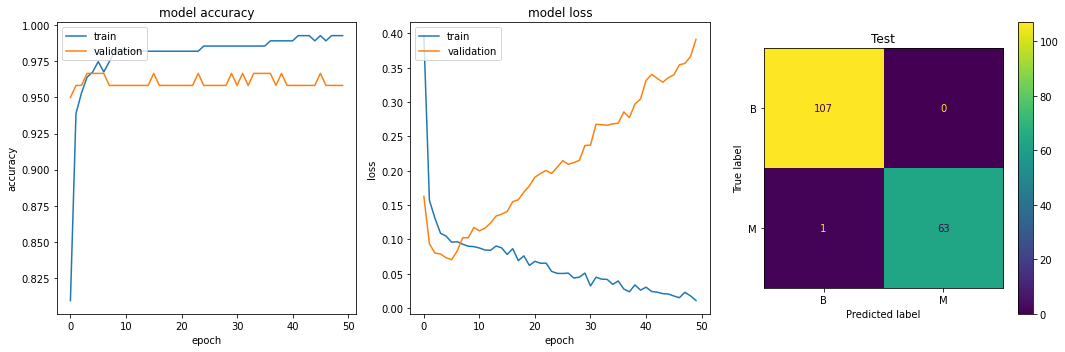

,B,M
Precision,0.990741,1.000000
Recall,1.000000,0.984375
F-Score,0.995349,0.992126
Support,107.000000,64.000000


In [16]:
def compile_loss_network ():
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation="relu", input_shape=(len(X_train.columns),)))
    network.add(layers.Dense(units=16, activation="gelu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy",
                    optimizer="rmsprop",
                    metrics=["accuracy"])
    return network

def network_overfitting_fit (network, X_train, y_train, X_validate, y_validate):
    return network.fit(X_train,
                       y_train,
                       epochs=50,
                       batch_size=1,
                       verbose=0,
                       validation_data=(X_validate, y_validate))

train_test_plot_network(compile_loss_network,
                        network_overfitting_fit,
                        X_train, y_train,
                        X_validate, y_validate,
                        X_test, y_test,
                        y_labels=encoder.classes_)

### Reducing Overfitting with Early Stopping

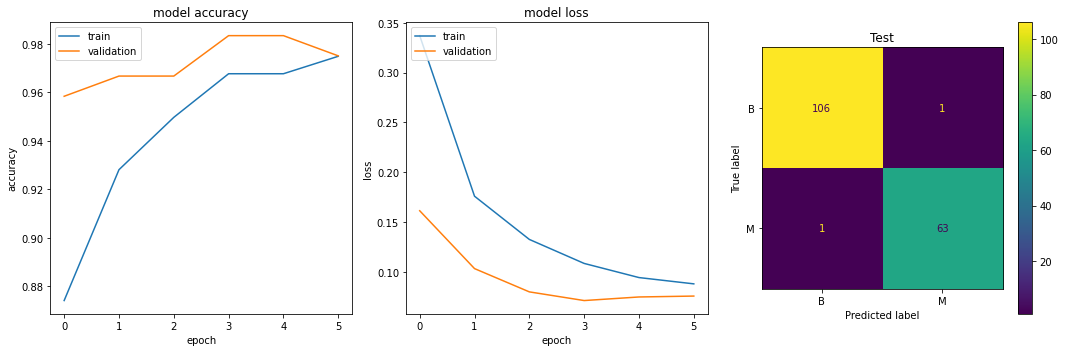

,B,M
Precision,0.990654,0.984375
Recall,0.990654,0.984375
F-Score,0.990654,0.984375
Support,107.000000,64.000000


In [17]:
def network_overfitting_fit (network, X_train, y_train, X_validate, y_validate):
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=2),
        # ModelCheckpoint(filepath="best_model.h5",
        #                 monitor="val_loss",
        #                 save_best_only=True)
    ]
    return network.fit(X_train,
                       y_train,
                       epochs=50,
                       batch_size=2,
                       callbacks=callbacks,
                       verbose=0,
                       validation_data=(X_validate, y_validate))

train_test_plot_network(compile_loss_network,
                        network_overfitting_fit,
                        X_train, y_train,
                        X_validate, y_validate,
                        X_test, y_test,
                        y_labels=encoder.classes_)

### Reducing Overfitting with Dropout

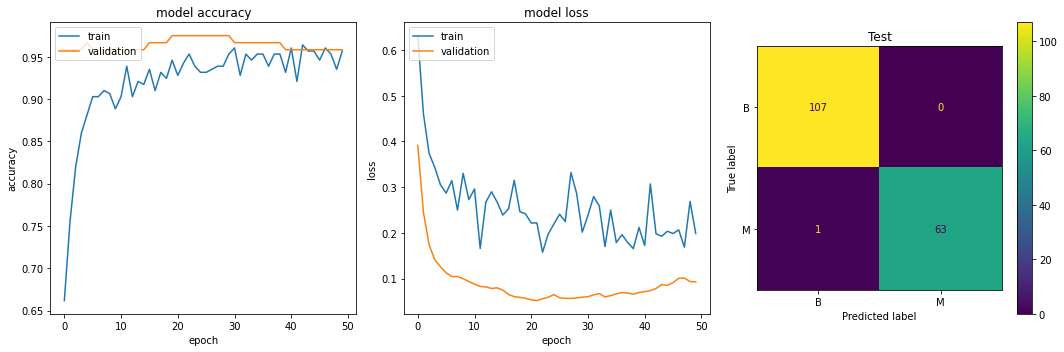

,B,M
Precision,0.990741,1.000000
Recall,1.000000,0.984375
F-Score,0.995349,0.992126
Support,107.000000,64.000000


In [18]:
def compile_dropout_network ():
    network = models.Sequential()
    network.add(layers.Dropout(0.2, input_shape=(len(X_train.columns),)))
    network.add(layers.Dense(units=16, activation="relu"))
    network.add(layers.Dropout(0.5))
    network.add(layers.Dense(units=16, activation="gelu"))
    network.add(layers.Dropout(0.5))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy",
                    optimizer="rmsprop",
                    metrics=["accuracy"])
    return network

def network_overfitting_fit (network, X_train, y_train, X_validate, y_validate):
    return network.fit(X_train,
                       y_train,
                       epochs=50,
                       batch_size=2,
                       verbose=0,
                       validation_data=(X_validate, y_validate))

train_test_plot_network(compile_dropout_network,
                        network_overfitting_fit,
                        X_train, y_train,
                        X_validate, y_validate,
                        X_test, y_test,
                        y_labels=encoder.classes_)

## k-Fold Cross-Validating Neural Networks

2022-03-15 21:40:53.250615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 21:40:53.250713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 21:40:53.290278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-15 21:40:53.290313: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries

Mean score 0.9603246753246755.
Max score 0.9821428571428571.


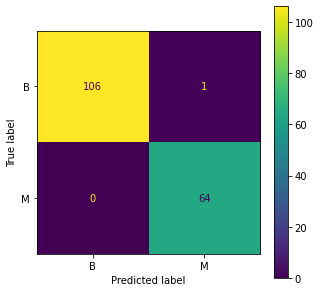

,B,M
Precision,1.000000,0.984615
Recall,0.990654,1.000000
F-Score,0.995305,0.992248
Support,107.000000,64.000000


In [19]:
from scikeras.wrappers import KerasClassifier

def cv_neural_network (X_train, y_train, X_test, y_test):
    neural_network = KerasClassifier(model=compile_simple_network,
                                     epochs=32,
                                     batch_size=32,
                                     verbose=0)

    results = cross_validate(neural_network, X_train, y_train, cv=5, return_estimator=True, n_jobs=-1)
    test_scores = results["test_score"]
    mean_score = test_scores.mean()
    max_score = test_scores.max()
    best_estimator = results["estimator"][test_scores.tolist().index(max_score)]
    predicted_y = best_estimator.predict(X_test)
    print(f"Mean score {mean_score}.")
    print(f"Max score {max_score}.")
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ConfusionMatrixDisplay.from_predictions(y_test, predicted_y, display_labels=encoder.classes_, ax=ax)
    plt.show()
    display(pd.DataFrame(data=precision_recall_fscore_support(y_test, predicted_y),
                         columns=encoder.classes_,
                         index=["Precision", "Recall", "F-Score", "Support"]))

cv_neural_network(X_train, y_train, X_test, y_test)

## GridSearchCV

In [20]:
from keras.wrappers.scikit_learn import KerasClassifier

def customizable_model (hidden_layers_count=1, units_count=16, activation_fn='relu', loss_fn='binary_crossentropy',
                        optimizer_fn='rmsprop'):
    network = models.Sequential()
    network.add(layers.Dense(units=16, activation=activation_fn, input_shape=(len(X_train.columns),)))
    for _ in range(hidden_layers_count):
        network.add(layers.Dense(units=units_count, activation=activation_fn))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss=loss_fn,
                    optimizer=optimizer_fn,
                    metrics=["accuracy"])
    return network

estimator = KerasClassifier(build_fn=customizable_model, verbose=0)

param_grid = dict(
    hidden_layers_count=[2, 4, 8],
    units_count=[8, 16],
    activation_fn=['relu', 'sigmoid'],
    loss_fn=['binary_crossentropy', 'hinge'],
    optimizer_fn=["rmsprop", "adam"],
    epochs=[32, 64],
    batch_size=[16, 32],
)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, verbose=0)
grid_result = grid.fit(X_train, y_train)
display(grid_result.best_score_)
display(grid_result.best_params_)

/tmp/ipykernel_372661/1797946774.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=customizable_model, verbose=0)
2022-03-15 21:40:59.696498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 21:40:59.790228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-15 21:40:59.790424: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://

0.9712337732315064

{'activation_fn': 'relu',
 'batch_size': 16,
 'epochs': 64,
 'hidden_layers_count': 8,
 'loss_fn': 'binary_crossentropy',
 'optimizer_fn': 'adam',
 'units_count': 8}